# Compare "Augment by 0/1" with "Insert c" using ambiguous dummy value

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import LSTM
from scipy.stats import norm, gaussian_kde
from scipy.integrate import solve_ivp, dblquad
import random

from bayesflow.networks import InvertibleNetwork
from bayesflow.amortizers import SingleModelAmortizer
from bayesflow.trainers import ParameterEstimationTrainer
from bayesflow.models import GenerativeModel

In [2]:
%load_ext autoreload
%autoreload 2

## Simulator settings

In [3]:
def prior(batch_size):
    """
    Samples from the prior 'batch_size' times.
    ----------
    Output:
    theta : np.ndarray of shape (batch_size, theta_dim) 
    """    
    # Prior range for log-parameters: k_1, k_2 ~ N(-0.75, 0.25²) iid.
    p_samples = np.random.normal(-0.75, 0.25, size=(batch_size, 2))
    return p_samples.astype(np.float32)


# ODE model for conversion reaction    
def conversion_reaction(t, x, theta):
    theta = 10**theta
    return np.array([-theta[0]*x[0]+theta[1]*x[1], theta[0]*x[0]-theta[1]*x[1]])

x0 = [1,0]   # initial condition       
sigma = 0.015   # noise standard deviation
n_obs = 3
time_points = np.linspace(0, 10, n_obs)
missing_max = 2

We build an amortized parameter estimation network.

In [4]:
bf_meta = {
    'n_coupling_layers': 5,
    's_args': {
        'units': [64, 64, 64],
        'activation': 'elu',
        'initializer': 'glorot_uniform',
    },
    't_args': {
        'units': [64, 64, 64],
        'activation': 'elu',
        'initializer': 'glorot_uniform',
    },
    'n_params': 2
}

## Computational faithfulness

In [5]:
# Data set 1
param_prior_1 = np.array([[-0.8 , -0.85]])
result_1 = [np.array([-0.02, 0.42, 0.501]), np.array([0, 2]), np.array([0., 10.])]

# Data set 2
param_prior_2 = np.array([[-0.8 , -0.85]])
result_2 = [np.array([-0.02, 0.42, 0.5]), np.array([0, 2]), np.array([0., 10.])]

# Data set 3
param_prior_3 = np.array([[-0.8 , -0.85]])
result_3 = [np.array([-0.02, 0.42, 0.52]), np.array([0]), np.array([0.])]

param_priors = [param_prior_1, param_prior_2, param_prior_3]
results = [result_1, result_2, result_3]

In [6]:
# Insert 0.5
summary_net = LSTM(8)
inference_net = InvertibleNetwork(bf_meta)
amortizer_insert = SingleModelAmortizer(inference_net, summary_net)
ParameterEstimationTrainer(network=amortizer_insert, checkpoint_path='./CR3_insert0.5_5ACB_[64,64,64]_LSTM(8)_ckpts', skip_checks=True)

# Augment by 0/1 (c=0.5)
summary_net = LSTM(8)
inference_net = InvertibleNetwork(bf_meta)
amortizer_augment01 = SingleModelAmortizer(inference_net, summary_net)
ParameterEstimationTrainer(network=amortizer_augment01, checkpoint_path='./CR3_augment01(0.5)_5ACB_[64,64,64]_LSTM(8)_ckpts', 
                           skip_checks=True)

amortizers = [amortizer_insert, amortizer_augment01, amortizer_augment01]

TRAINER INITIALIZATION: No generative model provided. Only offline learning mode is available!
Networks loaded from ./CR3_insert0.5_5ACB_[64,64,64]_LSTM(8)_ckpts\ckpt-300
TRAINER INITIALIZATION: No generative model provided. Only offline learning mode is available!
Networks loaded from ./CR3_augment01(0.5)_5ACB_[64,64,64]_LSTM(8)_ckpts\ckpt-300


In [7]:
# Encode missing data
x_datas = []

for i in range(len(results)): 
    result = results[i]
    
    if amortizers[i] == amortizer_insert:
        x_data = np.ones((1, n_obs, 1), dtype=np.float32)
        x_data[0, :, 0] = result[0]
        missing_indices = np.setdiff1d(range(n_obs), result[1])
        x_data[0][missing_indices] = np.array([0.5])
        
    else:
        x_data = np.ones((1, n_obs, 2), dtype=np.float32)
        x_data[0, :, 0] = result[0]
        missing_indices = np.setdiff1d(range(n_obs), result[1])
        x_data[0][missing_indices] = np.array([0.5, 0.0])
      
    x_datas.append(x_data)

In [8]:
# Sample from BayesFlow
n_post_samples = 2000
samples = []
for i in range(len(results)):
    x_data = x_datas[i]
    amortizer = amortizers[i]
    sample = amortizer.sample(x_data, n_post_samples)    
    samples.append(sample)

## Posterior plot

In [9]:
# Calculate analytical posteriors
def get_posterior(result):
    
    def prior_eval(x,y):   
        # Evaluates prior probability p(theta) according to k_1, k_2 ~ N(-0.75, 0.25²) iid.
        return norm.pdf(x,-0.75,0.25) * norm.pdf(y,-0.75,0.25)

    def likelihood(x,y):   
        # Calculates likelihood of available data
        x = 10**x
        y = 10**y
        s = x + y
        b = x/s
        state_2 = lambda t: b - b * np.exp(-s*t)
        sol = state_2(result[2])
        residual = (result[0][result[1]] - sol)/sigma
        nllh = np.sum(np.log(2*np.pi*sigma**2)+residual**2)/2
        return np.exp(-nllh)

    def unnormalized_posterior(x,y):   
        # Evaluates the unnormalized posterior probability according to Bayes' formula
        return likelihood(x,y) * prior_eval(x,y)
    
    # scaling factor
    scaling_factor = dblquad(unnormalized_posterior, -2.25, 0.75, lambda y: -2.25, lambda y: 0.75)

    posterior = lambda x,y: unnormalized_posterior(x,y) / scaling_factor[0]
    return posterior

posteriors = []
for i in range(len(results)):
    result = results[i]
    posterior = get_posterior(result)
    posteriors.append(posterior)

In [10]:
cmap = "viridis"

def plot_posterior(ax, posterior, param_samples, method, levels=None):
    mins, maxs = param_samples.min(axis=0), param_samples.max(axis=0)
    xmin, ymin = mins
    xmax, ymax = maxs
    
    # Level sets of analytic posterior distribution
    grid = 151
    A = np.linspace(xmin, xmax, grid)
    B = np.linspace(ymin, ymax, grid)
    true_posterior = np.zeros((grid, grid))
    for iy in range(0, grid):
        for ix in range(0, grid):
            true_posterior[iy][ix] = posterior(A[ix], B[iy]) 
    if levels is not None:
        _cs = ax.contour(A, B, true_posterior, levels, cmap=cmap)
    else:
        _cs = ax.contour(A, B, true_posterior, cmap=cmap)
    
    # Kernel density estimator of BayesFlow samples
    a = param_samples[:, 0]
    b = param_samples[:, 1]
    ab = np.vstack([a, b])
    z = gaussian_kde(ab)(ab)
    ida = z.argsort()  # Sort the points by density, so that the densest points are plotted last
    a, b, z = a[ida], b[ida], z[ida]
    approximate_posterior = ax.scatter(a, b, c=z, s=10, cmap=cmap, alpha=0.2)

    ax.set_xlabel('Parameter $k_1$')
    ax.set_ylabel('Parameter $k_2$')
    ax.set_title(method)

## Posterior predictive check

In [11]:
# Posterior predictive check
def plot_predictive_check(ax, param_prior, result, param_samples, n_sim=101):

    for k in range(n_sim):
        rhs = lambda t,x: conversion_reaction(t, x, param_samples[k])
        sol = solve_ivp(rhs, t_span = (0,10), y0 = x0, atol = 1e-9, rtol = 1e-6)   
        if k == 0:
            ax.plot(np.array([0]), np.array([0]), color='grey', label='Simulation', linewidth=0.9)
        else: 
            ax.plot(sol.t, sol.y[1], color='grey', linewidth=0.5, alpha=0.3)
            
    ax.plot(np.linspace(0, 10, 21), 0.5*np.ones(21), '--', color='tab:orange', linewidth=1)   # Dummy value
    
    rhs = lambda t,x: conversion_reaction(t, x, param_prior[0])
    sol = solve_ivp(rhs, t_span = (0,10), y0 = x0, atol = 1e-9, rtol = 1e-6)
    ax.plot(sol.t, sol.y[1], color='black', label='True trajectory')    
    
    present_indices = result[1]
    missing_indices = np.setdiff1d(range(n_obs), present_indices)
    ax.plot(time_points[present_indices], result[0][present_indices], 'o', label='Available data')
    ax.plot(time_points[missing_indices], result[0][missing_indices], 'o', color='red', label='Missing data')
    ax.plot(time_points[missing_indices], 0.5*np.ones(len(missing_indices)), 'o', color='tab:orange', label='Dummy value')
    ax.set_xlabel('Time $t$')
    ax.set_ylabel("Measurement $y$")

## Combined plot

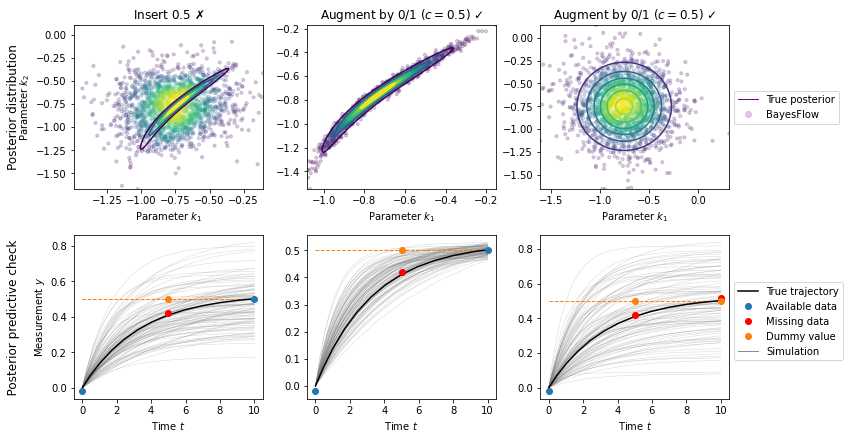

In [12]:
fig, axes = plt.subplots(2, 3, figsize=(12, 6.2))
methods = ["Insert $0.5$ ✗", "Augment by $0/1$ ($c=0.5$) ✓", "Augment by $0/1$ ($c=0.5$) ✓"]
level_sets = [np.array([3, 10, 20, 29]), np.array([3, 10, 20, 29]), None]

for j in range(len(results)):
    # Posterior plot
    ax = axes[0,j]
    plot_posterior(ax, posteriors[j], samples[j], methods[j], levels=level_sets[j])
    if j == 2:
        legend_elements = [
            Line2D([0], [0], color="purple", lw=1, label="True posterior"),
            Line2D([0], [0], color="purple", markerfacecolor="purple", marker="o", lw=0, markersize=6, alpha=0.2, label="BayesFlow"),
        ]
        ax.legend(handles=legend_elements, loc="center left", bbox_to_anchor=(1, 0.5))
    if j > 0:
        ax.set_ylabel(None)
    
    # Predictive check
    ax = axes[1,j]
    plot_predictive_check(ax, param_priors[j], results[j], samples[j])       
    if j == 2:
        handles, labels = ax.get_legend_handles_labels()
        order = [1,2,3,4,0]
        ax.legend([handles[idx] for idx in order],[labels[idx] for idx in order], bbox_to_anchor=(1,0.74))
    if j > 0:
        ax.set_ylabel(None)

fig.supylabel("   Posterior predictive check                  Posterior distribution   ")

fig.tight_layout()
for fmt in ["png", "pdf"]:
    fig.savefig(f"figures/CR3_augment_insert.{fmt}", dpi=300, bbox_inches='tight')